#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## ** Actividad Semana 9**

###**Modelos Transformer & LLM**

#### **Nombres y matrículas de los integrantes del equipo:**

*   Renzo Zagni A01795457
*   Angel Iván Ahumada Arguelles A00398508
*   Karina Zafra Vallejo A01793979
*   Ernesto Zapata Garza A00915255


In [1]:
#
# Instalamos las librerias de hugging face
!pip install datasets transformers huggingface_hub
#
# Requisito de transformer.Trainer()
!pip install transformers[torch]

#
# Instalamos las librerias evaluate
!pip install evaluate

#
# Recomendado por MarianTokenizer
# tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
!pip install sacremoses

#
# Instalamos las librerias de Google Gemini
!pip install -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [1]:
#
# Librerias requiridas durante la actividad
import os
import time
import numpy as np
import pandas as pd
import torch
import evaluate
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.metrics import ConfusionMatrixDisplay
from datasets import Dataset, load_metric, ClassLabel
from datasets.dataset_dict import DatasetDict
from transformers import DataCollatorWithPadding, MarianTokenizer, MarianMTModel
from transformers import TrainingArguments, Trainer,  DistilBertForSequenceClassification, DistilBertTokenizer

import warnings
warnings.filterwarnings("ignore")
#
# Requerimientos de Google Gemini
# https://ai.google.dev/gemini-api/docs/get-started/tutorial
import google.generativeai as genai
from google.colab import userdata
#
# Para formatear los dataframes en Colab
from google.colab import data_table

In [2]:
#
# Verificamos la disponibilidad del GPU
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/Colab Notebooks/NLP"
os.chdir(DIR)

Mounted at /content/drive


***1. Descarga el archivo amazonbaby5000.csv que se encuentra en Canvas. Este archivo está formado de 5 mil comentarios en inglés sobre productos para bebé adquiridos a través de la plataforma de Amazon.***

In [4]:
df = pd.read_csv('amazonbaby5000.csv', encoding='utf-8')

In [5]:
df.head()

,review,rating
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",1
2,We really like these valances. They have such...,1
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0


In [6]:
#
# Renombramos la columna rating a label para evitar error durante el entrenamiento
# del modelo transformer.Trainer()
# ValueError: The model did not return a loss from the inputs, only the following
# keys: logits. For reference, the inputs it received are input_ids,attention_mask
df.rename(columns={'rating': 'label'}, inplace=True)

In [7]:
print("Porcentage de classes positivas y negativas:")
df['label'].value_counts(normalize=True) * 100

Porcentage de classes positivas y negativas:


label
1    76.8
0    23.2
Name: proportion, dtype: float64

***2. Realiza una partición de los datos en el porcentaje que consideres adecuado, en entrenamiento y prueba.***


In [8]:
#
# Cargamos el DataFrame en un DataSet
amazon_ds = Dataset.from_pandas(df)
#
amazon_ds = amazon_ds.cast_column("label", ClassLabel(names=["positive", "negative"]))

# Revolvemos los datos para una mejor distribucion
amazon_ds.shuffle()
#
# Separamos los datos en 80% entrenamiento y 20% de prueba
amazon_dsd = amazon_ds.train_test_split(test_size=0.2, stratify_by_column="label")
#
amazon_dsd


Casting the dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 1000
    })
})

***3. Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento en inglés y lleva a cabo la predicción de los comentarios en los siguientes casos:***

***a. Utiliza uno de los modelos Transformer pre-entrenados que consideres adecuado de DistilBERT de Huggingface para análisis de sentimiento y lleva a cabo el entrenamiento y evaluación del desempeño con exatitud (accuracy) y matriz de confusión.***

***NOTA: Recuerda obtener el porcentaje de las clases positivas y negativas para tener una idea clara de si el modelo encontrado queda subentrenado.***

In [9]:

#
# Tokenizamos los datos
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
   return tokenizer(examples['review'], truncation=True)

tokenized_train =  amazon_dsd['train'].map(preprocess_function, batched=True)
tokenized_test =  amazon_dsd['test'].map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
#
# Definimos funcion para desplegar la matriz de confusion
def plot_confusion_matrix(tp,tn,fp,fn):
  cm = np.array([[tp, fn],
                 [fp, tn]])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positivo','Negativo'])
  disp.plot(cmap='Blues')
  plt.show()

In [11]:
#
# Definimos funcion para calcular matrix de confusion y accesar cada parametro
# por separado
def compute_confusion_matrix(predictions, references):
    tp = np.sum((predictions == 1) & (references == 1))
    tn = np.sum((predictions == 0) & (references == 0))
    fp = np.sum((predictions == 1) & (references == 0))
    fn = np.sum((predictions == 0) & (references == 1))

    return {
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    }

#
# Definimos la funcion con las metricas de evaluacion del modelo
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy",  trust_remote_code=True)
   # Separamos logits y etiquetas
   logits, labels = eval_pred
   # Extraemos position del logit mas alto de cada fila (0,1)
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   confusion_matrix = compute_confusion_matrix(predictions=predictions, references=labels)
   return {"accuracy": accuracy,
           "TP": confusion_matrix['TP'],
           "TN": confusion_matrix['TN'],
           "FP": confusion_matrix['FP'],
           "FN": confusion_matrix['FN']
           }
#
# Definimos los argumentos iniciales
training_args = TrainingArguments(
    output_dir='/tmp',
    logging_dir='/tmp',
    evaluation_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
)

from torch import nn
from transformers import Trainer

# Definimos parametros de la clase Trainer y la invocamos en la celda siguiente
# para iniciar el proceso de entrenamiento
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [12]:
trainer.train()
evaluation = trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,Tp,Tn,Fp,Fn
100,0.475800,0.382962,0.867000,746,121,111,22
200,0.389700,0.364381,0.875000,740,135,97,28
300,0.291800,0.368567,0.878000,698,180,52,70
400,0.312400,0.265727,0.890000,694,196,36,74
500,0.331800,0.262045,0.891000,738,153,79,30
600,0.144800,0.402157,0.900000,730,170,62,38
700,0.149400,0.418529,0.899000,733,166,66,35
800,0.223100,0.364092,0.908000,734,174,58,34
900,0.179800,0.373625,0.897000,731,166,66,37
1000,0.162200,0.342666,0.901000,722,179,53,46


Metrica de Desempeño
--------------------
Exactitud: 90.10%

Matriz de Confusion
-------------------
Rate de TP: 


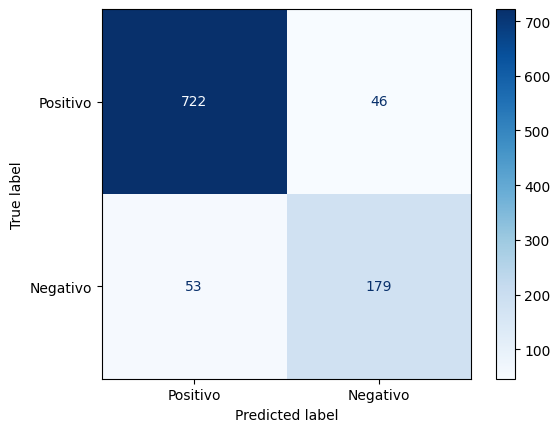

In [13]:
print("Metrica de Desempeño")
print("--------------------")
print("Exactitud: {:.2f}%".format(evaluation['eval_accuracy'] * 100))
print()
print("Matriz de Confusion")
print("-------------------")
print("Rate de TP: ")
plot_confusion_matrix(evaluation['eval_TP'], evaluation['eval_TN'], evaluation['eval_FP'], evaluation['eval_FN'])

<font color=blue>COMENTARIOS:  La exactitud es del 90.1% lo que indica un desempeño bastante bueno. Por otro lado, podemos observar que el radio entre FP y FN es mucho mas bajo que el radio de las etiquetas en el conjunto de datos. Esto puede ser el resultado de falta de entrenamiento --lo que mejoraremos en el paso del fine-tuning -- asi como de algunos comentarios ambiguos donde se resaltan tanto aspectos positivos y negativos del producto sobre el que se hace el comentario </font>

***b. Realiza una partición del conjunto de entrenamiento en uno nuevo de entrenamiento y validación, con los porcentajes que consideres adecuados y utilizando el mismo modelo DistilBERT del inciso anterior, ajusta sus hiperparámetros (fine-tuning) para entrenar y evaluar el desempeño de este nuevo modelo.***

In [38]:
#
# Creamos DataSetDict con una particion de la data de entrenamiento y validacion 80/20
amazon_dsd_ft = amazon_dsd['train'].train_test_split(test_size=0.2, stratify_by_column="label")
#
#
# Renombramos la llave "test" a "valid" para mantener consitencia a lo largo del
# ejercicio
dsd_test_tmp = amazon_dsd_ft.pop('test')
amazon_dsd_ft['valid'] = dsd_test_tmp
del dsd_test_tmp

tokenized_train_ft =  amazon_dsd_ft['train'].map(preprocess_function, batched=True)
tokenized_valid_ft =  amazon_dsd_ft['valid'].map(preprocess_function, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [42]:
#
# Definimos los argumentos de entrenamiento ajustando los hiperparametros
training_args_ft = TrainingArguments(
    output_dir='/tmp',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="steps",
    logging_dir='/tmp',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Definimos parametros de la clase Trainer y la invocamos en la celda siguiente
# para iniciar el proceso de entrenamiento
trainer_ft = Trainer(
   model=model,
   args=training_args_ft,
   train_dataset=tokenized_train_ft,
   eval_dataset=tokenized_valid_ft,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [43]:
trainer_ft.train()
evaluation_ft = trainer_ft.evaluate()

Step,Training Loss,Validation Loss,Accuracy,Tp,Tn,Fp,Fn
100,0.032400,0.512932,0.931250,595,150,36,19
200,0.032900,0.495523,0.932500,583,163,23,31
300,0.002500,0.603390,0.933750,590,157,29,24
400,0.006200,0.614417,0.932500,586,160,26,28
500,0.006100,0.596757,0.931250,589,156,30,25
600,0.006700,0.623109,0.935000,598,150,36,16


Metrica de Desempeño
--------------------
Exactitud: 93.12%

Matriz de Confusion
-------------------


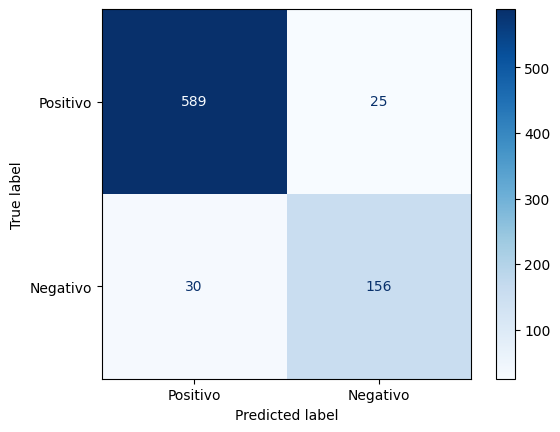

In [44]:
print("Metrica de Desempeño")
print("--------------------")
print("Exactitud: {:.2f}%".format(evaluation_ft['eval_accuracy'] * 100))
print()
print("Matriz de Confusion")
print("-------------------")
plot_confusion_matrix(evaluation_ft['eval_TP'], evaluation_ft['eval_TN'], evaluation_ft['eval_FP'], evaluation_ft['eval_FN'])

***c. Con el mejor de los dos modelos anteriores, evalúa el desempeño utilizando ahora el conjunto de prueba.***

In [45]:
predicciones = trainer_ft.predict(tokenized_test)

Metrica de Desempeño
--------------------
Exactitud: 90.10%

Matriz de Confusion
-------------------


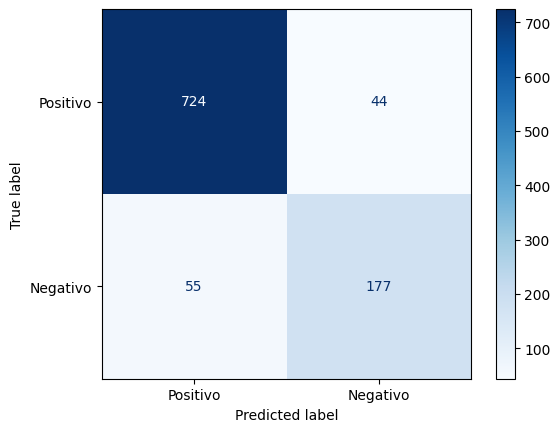

In [46]:
print("Metrica de Desempeño")
print("--------------------")
print("Exactitud: {:.2f}%".format(predicciones.metrics['test_accuracy'] * 100))
print()
print("Matriz de Confusion")
print("-------------------")
plot_confusion_matrix(predicciones.metrics['test_TP'], predicciones.metrics['test_TN'], predicciones.metrics['test_FP'], predicciones.metrics['test_FN'])

***d. Incluye tus comentarios.***

<font color=blue>**Comentarios sobre el analisis de sentimiento utilizando los modelos Hugging Face:**</font>

<font color=blue>Durante la primera ejecución del modelo, sin realizar ajustes significativos en sus hiperparámetros, logramos una exactitud es del 90.1%. Por otro lado, podemos observar que el radio entre FP y FN es mucho mas bajo que el radio de las etiquetas en el conjunto de datos. Alli especulamos que esta diferencia podria ser la causa de algunos comentarios ambiguos donde se resaltan tanto aspectos positivos y negativos del producto sobre el que se hace el comentarios o debido al desbalanceo de las clases</font

<font color=blue>Al ajustar los hiperparámetros del modelo, logramos una mejora significativa. La exactitud aumentó al 93.12% . En este punto seleccionamos este modelo para ejecutar las predicciones y validar el desempeño final del modelo</font>

<font color=blue>Al ejecutar la prediccion del modelo con los datos de prueba obtuvimos una exactitud de 90.1%. Este fue el resultado que mejor se aproximo a la exactitud obtenida en el proceso de fine-tuning </font>

<font color=blue>Es importante resaltar que para obtener este desempeño se debio entrenar el modelo en varias oportunidades a medida que comparabamos los resultados entre el modelo pre-entrenado, en modelo "fine-tuned" y los resultados de las predicciones. Un punto interezante fue observar lo facil que el modelo se puede sobre-entrenar con pequenas modificaciones de sus hiper-parametros durante el proceso de fine-tuning.</font>


***4. En este ejercicio vas a realizar una comparación simple entre un modelo Transformer pre- entrenado para traducción de inglés a español, con un modelo LLM (Large Language Model). Para ello selecciona de manera aleatoria 10 comentarios del conjunto de AmazonBaby5000.***

In [49]:
#
# Obtenemos 10 comentarios de manera aleatoria
amazon_10 = df['review'].sample(n=10, random_state=1).to_numpy()
#
# Desplegamos los comentarios para verificar
for text in amazon_10:
  print(text)

The product seems solid at this point, I've stepped on it, the boy has stomped all over it and it still works fine.The biggest complaint is the volume.  I have turned this thing all the way up and can kind of see why the boy doesn't really get into that much, the volume is too low to really capture his attention.Yes I KNOW HOW TO TURN THIS UP.  I have tried replacing the batteries on the unit and still it is quiet.So it distracts him for about 2-3mins if that and then he'll get bored.BTW my son is 10months old, just so you can use something as a reference point.The sound quality is all well and good, the amount of variety of songs isn't bad for the money and size of this product.
I love this caddy. Super cute. I use it as a diaper caddy on the first floor, because the changing table is on the second story of our home. It holds enough size ones and size fives for a couple of days, plus some wipes, diaper cream, and a folded changing mat. Really helpful and functional.
This is a great se

***a. Utiliza el modelo Tansformer pre-entrenado para traducción de inglés a español llamado Helsinki-NLP/opus-mt-en-es de Huggingface y traduce los 10 comentarios que seleccionaste.***

In [56]:
#
# Definimos arreglo de salida para capturar las traducciones
HNLP_text_es = []
timex = []
#
# Definimos tokenizador y modelo para la traducción
tokenizer_HNLP = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model_HNLP = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-es")
#
# Iteramos sobre los diez comentarios en el arreglo
for text in amazon_10:
  start_time = time.time()
  encoded_text = tokenizer_HNLP(text, return_tensors="pt")
  translated_tokens = model_HNLP.generate(
      input_ids=encoded_text['input_ids'],
      attention_mask=encoded_text['attention_mask']
  )
  timex.append(time.time() - start_time)

  HNLP_text_es.append(tokenizer_HNLP.decode(translated_tokens[0], skip_special_tokens=True))

print("Tiempo promedio de procesamiento por comentario " + str(round(mean(timex), 2))+ " segundos")

Tiempo promedio de procesamiento por comentario 3.57 segundos


In [51]:
#
# Desplegamos las traducciones para verificar
for texto in HNLP_text_es:
  print(texto)

El producto parece sólido en este punto, lo he pisado, el chico lo ha pisado todo y todavía funciona bien.La queja más grande es el volumen.He puesto esta cosa todo el camino hacia arriba y puedo ver por qué el niño realmente no se mete en tanto, el volumen es demasiado bajo para captar realmente su atención.Sí sé cómo encender esto.He tratado de reemplazar las baterías de la unidad y todavía está tranquilo.Así que le distrae por unos 2-3 minutos si eso y luego se aburrirá.BTW mi hijo tiene 10 meses de edad, sólo para que pueda utilizar algo como punto de referencia.La calidad del sonido está bien y es buena, la cantidad de variedad de canciones no es mala para el dinero y el tamaño de este producto.
Me encanta este caddy. Súper lindo. Lo uso como un caddy pañal en el primer piso, porque la mesa de cambio está en la segunda historia de nuestro hogar. Tiene suficientes tamaños y tamaños cinco para un par de días, además de algunas toallitas, crema de pañal, y un cambiador doblado. Realm

***b. Utiliza ahora el LLM Gemini de Google a través de su API para traducir los mismos 10 comentarios del inciso anterior. NOTA: deberás proponer el prompt que consideres adecuado para la traducción, incluyendo si consideras que ayuda, que tome en cuenta errores tipográficos (typos), o algún otro tipo de consideración.***

***NOTA: Puedes consultar la siguiente liga para familiarizarte con la API de Gemini:
https://ai.google.dev/gemini-api/docs/get-started/tutorial?hl=es-419&lang=python***

In [52]:
#
# Configuramos Gemini API Key
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [53]:
#
# Se creo un programa recursivo para volver a intentar las llamadas a la API al encontrase algun
# error de quotas o coneccion como:
# WARNING:tornado.access:429 POST /v1beta/models/gemini-1.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 353.68ms

#
# Inicializamos el modelo
model = genai.GenerativeModel('gemini-1.5-pro')

#
# Definimos excepcion para gestionar el maximo numero de intentos de llamada a
# la API de Google Gemini
class MaximosIntentos(Exception):
    def __init__(self, message="Numero Maximo de Intentos Alcanzados"):
        self.message = message
        super().__init__(self.message)

# Output list to capture the translations
gemini_text_es = []

# Initialize counter outside of the function to keep track of attempts
cnt = 0
max_retries = 5
timex = []

def append_to_gemini_text_es(text):
    global gemini_text_es
    gemini_text_es.append(text)

def iterador(start, end, matriz, max_retries=5):
    global cnt
    try:
        if start >= end:
            return gemini_text_es

        # En caso de error intentamos otra vez
        # Suspendemos la ejecuccion al alcanzar el limite max_retries
        cnt += 1
        if cnt > end + max_retries:
            raise MaximosIntentos()

        prompt = "Translate the following text from English to Spanish without including formatting options: " + matriz[start]
        start_time = time.time()
        response = model.generate_content(prompt)
        timex.append(time.time() - start_time)
        append_to_gemini_text_es(response.text.rstrip())

        # Pausamos la ejecucion para evitar sobrepasar la quota o ser bloqueados
        time.sleep(10)
        start += 1
        return iterador(start, end, matriz, max_retries)

    except MaximosIntentos as e:
        print(e)
        return gemini_text_es

    except Exception as e:
        # Pausamos la ejecucion para evitar sobrepasar la quota o ser bloqueados
        time.sleep(10)
        return iterador(start, end, matriz, max_retries)

start = 0
end = amazon_10.shape[0]
gemini_text_es = iterador(start, end, amazon_10)
print("Tiempo promedio de procesamiento por comentario " + str(round(mean(timex), 2))+ " segundos")

Tiempo promedio de procesamiento por comentario 4.44 segundos


In [35]:
#
# Desplegamos las traducciones para verificar
for texto in gemini_text_es:
  print(texto)

El producto parece sólido en este momento, lo he pisado, el niño ha brincado encima y todavía funciona bien. La mayor queja es el volumen. He subido el volumen al máximo y puedo entender por qué al niño realmente no le llama mucho la atención, el volumen es demasiado bajo para captar realmente su atención. Sí, SÉ CÓMO SUBIR EL VOLUMEN. He intentado reemplazar las baterías de la unidad y aún así suena bajo. Entonces, lo distrae durante unos 2-3 minutos como máximo y luego se aburre. Por cierto, mi hijo tiene 10 meses, solo para que puedan usar algo como punto de referencia. La calidad del sonido es buena, la cantidad de variedad de canciones no está mal para el precio y el tamaño de este producto.
Me encanta este organizador. Es súper lindo. Lo uso como organizador de pañales en el primer piso, porque el cambiador está en el segundo piso de nuestra casa. Tiene capacidad suficiente para pañales talla uno y talla cinco para un par de días, además de algunas toallitas, crema para pañales y

***c. Despliega ambas traducciones de manera tabular y compara los resultados obtenidos. Incluye tus conclusiones y los pros y contras que detectas en cada técnica.***

***NOTA: Aunque la comparación será de manera subjetiva, el punto de vista de una persona es muy valioso y nos puede proporcionar una buena idea de los desempeños de los modelos.***

In [36]:
#
# Definimos estilos para hacer la tabla comparativa mas legible
def style_dataframe(df):
    return df.style.set_table_styles([
        {'selector': 'td', 'props': [('vertical-align', 'top'), ('text-align', 'left')]},
        {'selector': 'th', 'props': [('text-align', 'center')]}
    ])
#
# Concatenamos las matrices con las ambas traducciones para comparalas una al lado
# de la otra
hnlp_gemini_arr = np.vstack((amazon_10, HNLP_text_es, gemini_text_es)).T
#
# Convertimos el arreglo en data frame
es_df = pd.DataFrame(hnlp_gemini_arr, columns=['Texto Original', 'HNLP', 'Gemini'])
#
# Aplicamos estilos
data_table.enable_dataframe_formatter()
es_df = style_dataframe(es_df)
es_df

,Texto Original,HNLP,Gemini
0,"The product seems solid at this point, I've stepped on it, the boy has stomped all over it and it still works fine.The biggest complaint is the volume. I have turned this thing all the way up and can kind of see why the boy doesn't really get into that much, the volume is too low to really capture his attention.Yes I KNOW HOW TO TURN THIS UP. I have tried replacing the batteries on the unit and still it is quiet.So it distracts him for about 2-3mins if that and then he'll get bored.BTW my son is 10months old, just so you can use something as a reference point.The sound quality is all well and good, the amount of variety of songs isn't bad for the money and size of this product.","El producto parece sólido en este punto, lo he pisado, el chico lo ha pisado todo y todavía funciona bien.La queja más grande es el volumen.He puesto esta cosa todo el camino hacia arriba y puedo ver por qué el niño realmente no se mete en tanto, el volumen es demasiado bajo para captar realmente su atención.Sí sé cómo encender esto.He tratado de reemplazar las baterías de la unidad y todavía está tranquilo.Así que le distrae por unos 2-3 minutos si eso y luego se aburrirá.BTW mi hijo tiene 10 meses de edad, sólo para que pueda utilizar algo como punto de referencia.La calidad del sonido está bien y es buena, la cantidad de variedad de canciones no es mala para el dinero y el tamaño de este producto.","El producto parece sólido en este momento, lo he pisado, el niño ha brincado encima y todavía funciona bien. La mayor queja es el volumen. He subido el volumen al máximo y puedo entender por qué al niño realmente no le llama mucho la atención, el volumen es demasiado bajo para captar realmente su atención. Sí, SÉ CÓMO SUBIR EL VOLUMEN. He intentado reemplazar las baterías de la unidad y aún así suena bajo. Entonces, lo distrae durante unos 2-3 minutos como máximo y luego se aburre. Por cierto, mi hijo tiene 10 meses, solo para que puedan usar algo como punto de referencia. La calidad del sonido es buena, la cantidad de variedad de canciones no está mal para el precio y el tamaño de este producto."
1,"I love this caddy. Super cute. I use it as a diaper caddy on the first floor, because the changing table is on the second story of our home. It holds enough size ones and size fives for a couple of days, plus some wipes, diaper cream, and a folded changing mat. Really helpful and functional.","Me encanta este caddy. Súper lindo. Lo uso como un caddy pañal en el primer piso, porque la mesa de cambio está en la segunda historia de nuestro hogar. Tiene suficientes tamaños y tamaños cinco para un par de días, además de algunas toallitas, crema de pañal, y un cambiador doblado. Realmente útil y funcional.","Me encanta este organizador. Es súper lindo. Lo uso como organizador de pañales en el primer piso, porque el cambiador está en el segundo piso de nuestra casa. Tiene capacidad suficiente para pañales talla uno y talla cinco para un par de días, además de algunas toallitas, crema para pañales y un cambiador plegable. Realmente útil y funcional."
2,"This is a great seat and a lifesaver when we go out to eat. The tray is essential for a toddler who eats with his hands. It also keeps him from grabbing silverware, glasses, tableclothes, etc. and keeps him happy for about an hour. Some problems with this seat: heavy to travel with, straps are not easy to put away when the seat is folded, hard to carry with the tray. I still love this seat even with these problems and I haven't found a better one that comes with a tray.","Este es un gran asiento y un salvavidas cuando salimos a comer. La bandeja es esencial para un niño pequeño que come con sus manos. También le impide agarrar cubiertos, vasos, manteles, etc. y lo mantiene feliz durante aproximadamente una hora. Algunos problemas con este asiento: pesado para viajar con, correas no son fáciles de guardar cuando el asiento está doblado, difícil de llevar con la bandeja. Todavía me encan

<font color=blue>**Comentarios sobre los modelos LLM para generar traducciones:**</font>

<font color=blue>Si bien ambos modelos generaron buenas traducciones, somos de la opinion que el modelo Gemini es un poco mas sofisticado a nivel de las palabras que utiliza , entendimiento del contexto y el uso de extensiones gramaticales para preservar el significado del mensaje durante la traduccion.</font>

<font color=blue>Por ejemplo , en la traduccion del 3rd comentario "I have an UPPA VISTA", el modelo Helsinsky-NLP (HNLP) de HuggingFace realize una traduccion literal "Tengo una UPPA VISTA" mientras que Gemini extendio la traduccion incluyendo informacion addicional que la enriquese "Tengo una carriola UPPA VISTA" . Esto puede ser muy util en algunos tipos de traducciones pero podria ser problematico en traducciones que requieran metodos que sigan el texto al pie de la letra como las literaturas tecnicas o cientificas.</font>

<font color=blue><font color=blue>Podemos tambien observar que en el caso de la oracion "My daugther loved this swing" HNLP se queda un poco corto "A mi hija le encantaba este columpio" --que se entiende como si ya la hija no tubiera acceso al columpio-- versus Gemini "A mi hija le encantó este columpio" la cual es mucho mas precisa.</font>

En cuanto al desempeño de la ejecuccion de las traducciones, HNLP fue un poco mas rapido en traduccir comentarios con un tiempo de procesamiento promedio de 3.33 segundos mientras que Gemini requirio 4.44 segundos. Gemini nos sorprendio debido al alto numero de errores y desconnexiones inclusive al respectar las quotas de sus API. </font>

<font color=blue>**Concluciones Finales:**</font>

<font color=blue> Esta asignacion nos sirvio para profundizar y reforzar nuestros conocimientos sobre los modelos Transformers y su uso en aplicaciones de analisis de sentimiento y para traducir texto. Aqui pudimos observar el poder y la flexibilidad de estos modelos Transformer para afrontar o resolver una gran cantidad de desafios de NLP.</font>

<font color=blue>Entre los puntos que mas nos llamo la atencion cabe mencionar los siguientes:</font>
*   <font color=blue>El poder de los modelos Transformer pre-entrenados y como estos logran facilmente una exactitud del 90%.<blue>
*   <font color=blue>La sensibilidad de los hyper paramtetros de los modelos de HuggingFace y la facilidad con que el modelo se puede sobre-entrenar.<blue>
*   <font color=blue>Las diferencias , si bien sutiles, entre los pragmatismos y las sintaxis de los modelos HNLP y Gemini y de como estos utilizan el contexto de los comentarios para mantener o mejorar la semantica de las traducciones vs traducciones mas literales que en algunos casos pierden un poco de sentido</font>


